# Supply Chain Demand Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


## EDA

In [2]:
#Load the dataset
df=pd.read_csv("/content/Adjusted_Supply_Chain_Demand_Data.csv")
df

,Product_ID,Category,Price,Promotion,Discount,Shelf_Life,Inventory_Level,Units_Sold,Stockouts,Lead_Time,...,Rainfall,GDP,Inflation_Rate,Unemployment_Rate,Customer_Age_Group,Customer_Income,Customer_Location,Lag_Sales_1,Rolling_Avg_3_Months,Target_Sales
0,P055,Electronics,497.68,1,0.30,Medium,235.0,28.0,0.0,4.0,...,39.6,4119.178355,8.044989,5.569380,51+,70318.197153,Suburban,27,24.54,34.0
1,P062,Toys,68.53,1,0.47,Medium,354.0,31.0,0.0,24.0,...,176.8,3596.123360,9.033971,14.454108,51+,84600.394100,Urban,2,22.01,89.0
2,P036,Furniture,430.64,1,0.40,Long,204.0,43.0,0.0,6.0,...,176.9,4719.609941,8.491933,12.200076,18-25,78485.239855,Suburban,2,16.30,2.0
3,P009,Electronics,48.00,1,0.00,Long,379.0,48.0,1.0,18.0,...,62.0,4907.635367,8.025970,7.752658,18-25,109481.313998,Rural,12,12.75,84.0
4,P075,Grocery,197.45,1,0.03,Short,354.0,21.0,1.0,22.0,...,95.7,2037.573215,7.075026,5.791751,51+,108840.225453,Suburban,49,17.57,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P005,Grocery,7.55,1,0.48,Medium,131.0,10.0,1.0,3.0,...,17.6,1432.610148,4.773740,10.795096,26-35,32815.023634,Rural,28,17.53,57.0
996,P047,Clothing,113.38,1,0.28,Short,193.0,45.0,1.0,19.0,...,147.1,5120.045955,6.903856,5.832182,18-25,82990.076900,Rural,47,13.94,46.0
997,P085,Grocery,193.57,1,0.36,Short,18.0,18.0,1.0,30.0,...,91.0,2053.454090,2.577059,4.973022,26-35,57713.160760,Urban,28,25.14,27.0
998,P096,Furniture,144.96,0,0.17,Short,195.0,38.0,0.0,31.0,...,19.4,2997.419531,4.697665,10.279600,51+,90027.872007,Rural,9,19.30,42.0


In [3]:
#Check for null values
df.isnull().sum()

,0
Product_ID,0
Category,0
Price,0
Promotion,0
Discount,0
Shelf_Life,0
Inventory_Level,0
Units_Sold,0
Stockouts,0
Lead_Time,0


In [4]:
df.describe()

,Price,Promotion,Discount,Inventory_Level,Units_Sold,Stockouts,Lead_Time,Supplier_Reliability,Month,Holiday,Temperature,Rainfall,GDP,Inflation_Rate,Unemployment_Rate,Customer_Income,Lag_Sales_1,Rolling_Avg_3_Months,Target_Sales
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,253.293390,0.497000,0.246540,247.425000,25.810000,0.519000,16.467000,0.899670,6.335000,0.49000,12.924900,97.942100,3108.830658,5.175524,9.182988,71549.992583,24.709000,20.080670,51.817000
std,147.218413,0.500241,0.149187,137.671689,14.573822,0.499889,9.478014,0.059167,3.488975,0.50015,12.904356,57.824444,1195.864827,2.464601,3.439998,29046.964479,14.809647,5.605526,31.054886
min,5.040000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.800000,1.000000,0.00000,-9.800000,0.100000,1037.191869,0.950944,3.032330,20262.651704,0.000000,10.060000,0.000000
25%,121.235000,0.000000,0.110000,127.000000,13.000000,0.000000,9.000000,0.850000,3.000000,0.00000,1.900000,45.400000,2132.304964,3.040644,6.246600,46438.408419,12.000000,15.152500,24.000000
50%,258.575000,0.000000,0.250000,248.000000,26.000000,1.000000,16.000000,0.900000,6.000000,0.00000,13.150000,97.150000,3170.500381,5.168382,9.091937,72372.617555,25.000000,20.180000,53.000000
75%,377.912500,1.000000,0.380000,368.250000,38.000000,1.000000,25.000000,0.950000,9.000000,1.00000,23.700000,147.950000,4112.802727,7.279479,12.230399,96693.471156,38.000000,24.980000,78.000000
max,498.150000,1.000000,0.500000,488.000000,50.000000,1.000000,32.000000,1.000000,12.000000,1.00000,34.900000,199.900000,5168.785241,9.499934,15.151544,121513.117979,50.000000,30.000000,105.000000


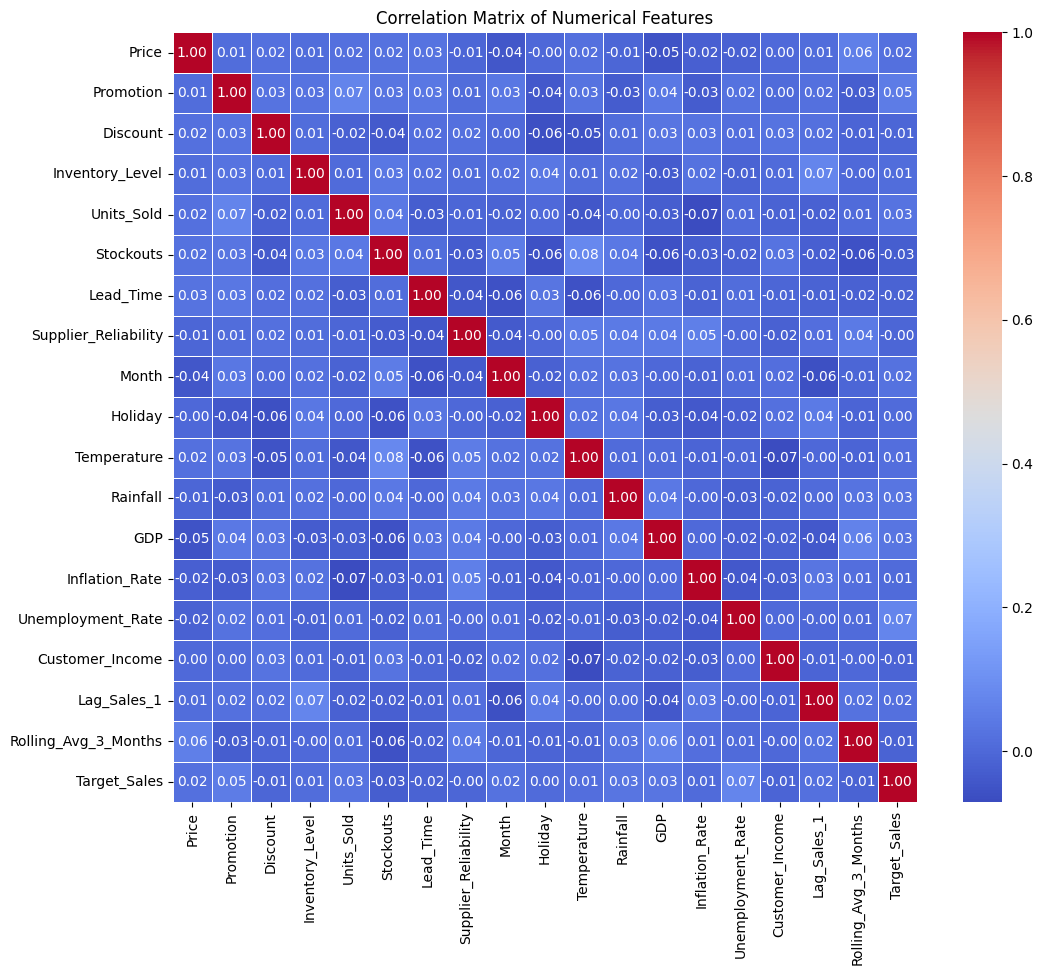

Target_Sales            1.000000
Unemployment_Rate       0.071305
Promotion               0.047292
Rainfall                0.031369
GDP                     0.030639
Units_Sold              0.025077
Month                   0.021427
Lag_Sales_1             0.020256
Price                   0.019214
Temperature             0.012635
Inventory_Level         0.011947
Inflation_Rate          0.005971
Holiday                 0.004877
Supplier_Reliability   -0.004898
Discount               -0.005901
Customer_Income        -0.011782
Rolling_Avg_3_Months   -0.014938
Lead_Time              -0.015034
Stockouts              -0.025665
Name: Target_Sales, dtype: float64


In [5]:

# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidth=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Correlation with Target_Sales
if "Target_Sales" in correlation.columns:
    target_corr = correlation["Target_Sales"].sort_values(ascending=False)
    print(target_corr)
else:
    print("Target_Sales column is not found in the numerical data.")


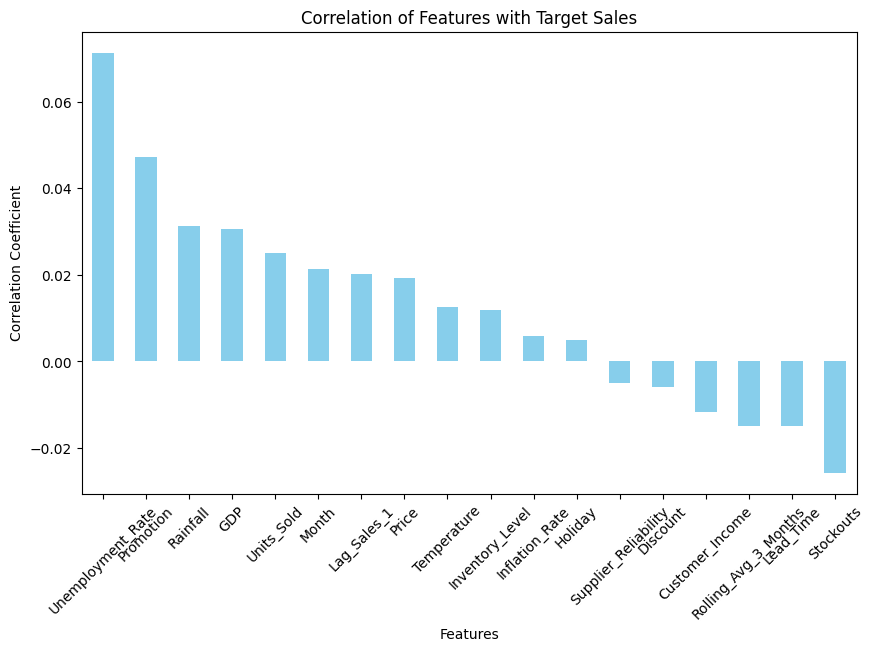

In [6]:
# Bar Plot of Correlation with Target Sales
plt.figure(figsize=(10, 6))
target_corr.drop('Target_Sales').plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target Sales')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

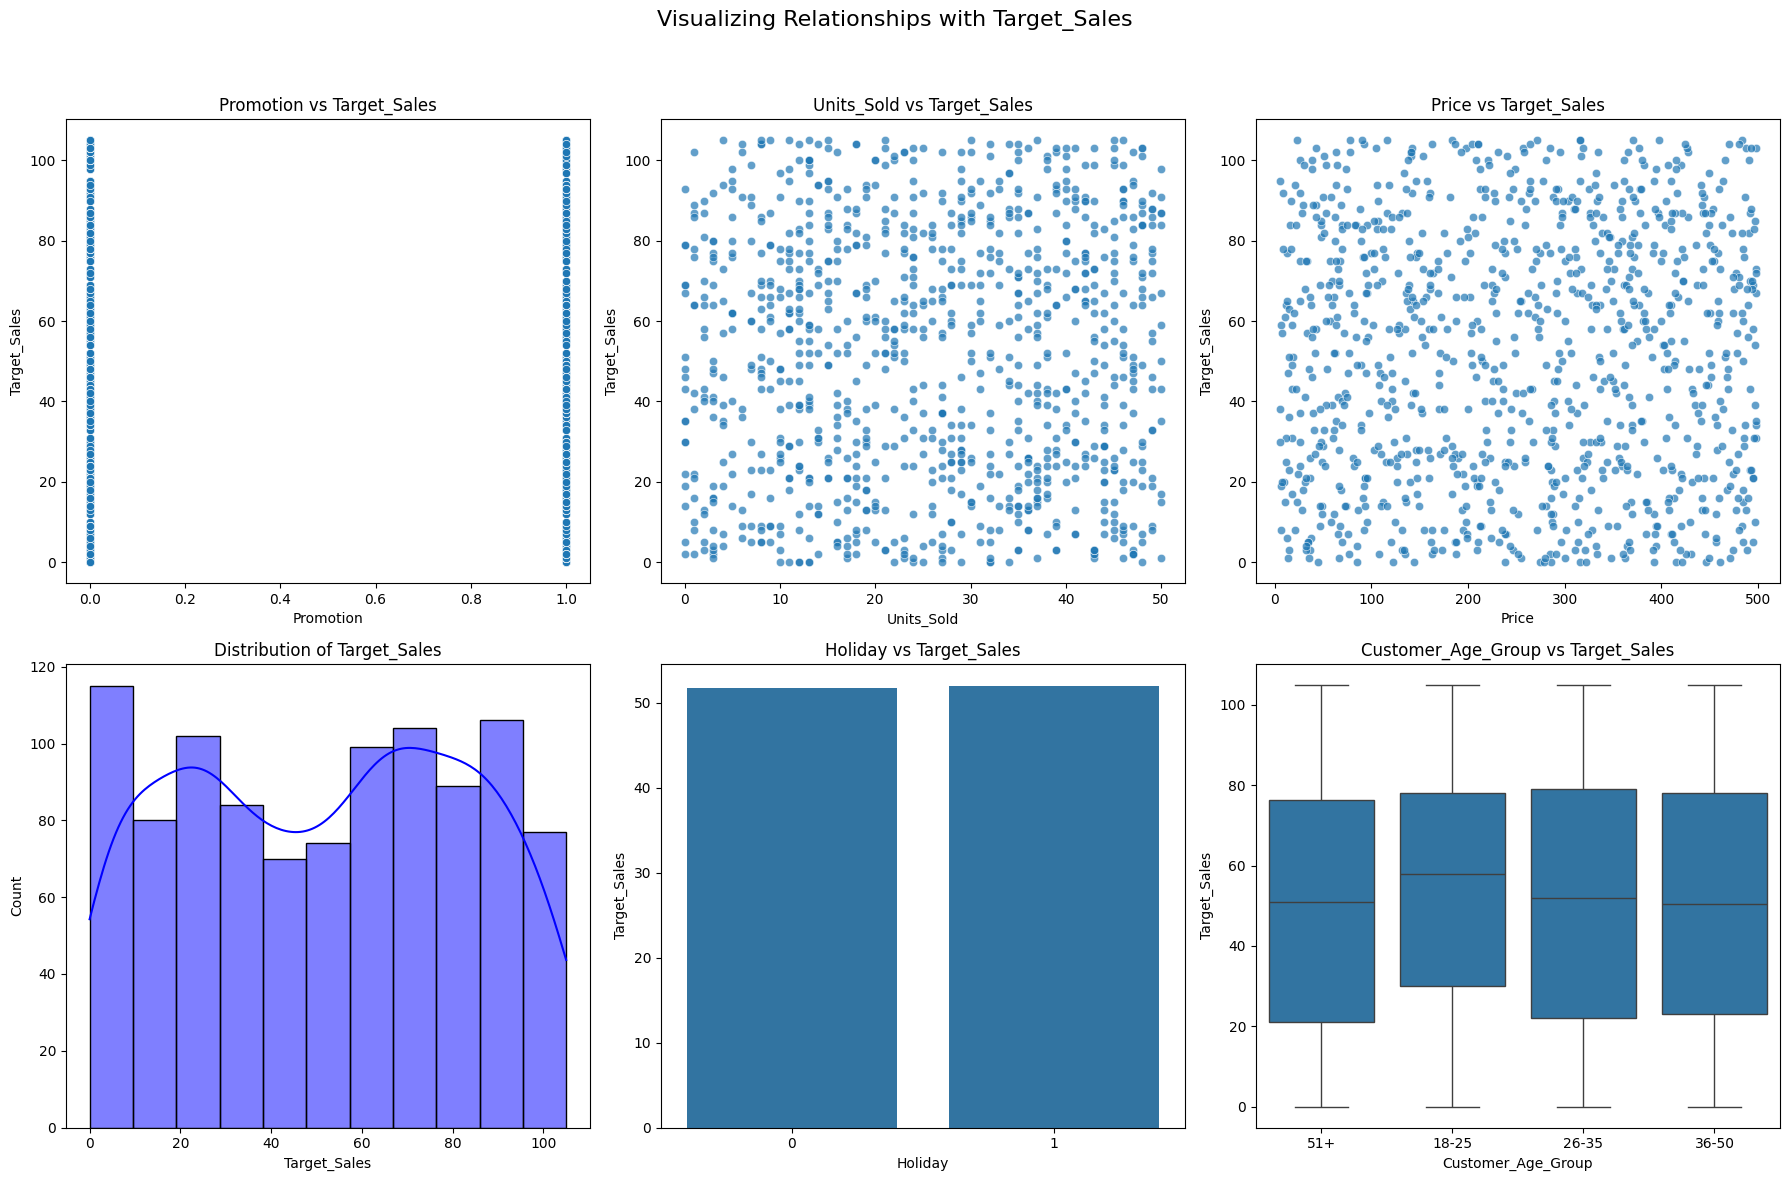

In [7]:
# Visualize key relationships with Target_Sales
data=df
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Visualizing Relationships with Target_Sales", fontsize=16)

# Scatterplot: Promotion vs Target_Sales
sns.scatterplot(ax =axes[0, 0], x =data['Promotion'], y=data['Target_Sales'])
axes[0, 0].set_title('Promotion vs Target_Sales')

# Scatterplot: Units_Sold vs Target_Sales
sns.scatterplot(ax= axes[0, 1], x=data['Units_Sold'], y=data['Target_Sales'], alpha=0.7)
axes[0, 1].set_title('Units_Sold vs Target_Sales')

# Scatterplot: Price vs Target_Sales
sns.scatterplot (ax =axes[0, 2], x=data['Price'], y=data['Target_Sales'],alpha=0.7)
axes[0, 2].set_title('Price vs Target_Sales')

# Distribution: Target_Sales
sns.histplot( ax=axes[1, 0], data=data,x='Target_Sales', kde= True, color='blue')
axes[1, 0].set_title('Distribution of Target_Sales')

# Barplot: Holiday vs Target_Sales
sns.barplot(ax=axes[1, 1],x=data['Holiday'], y= data['Target_Sales'], errorbar=None)
axes[1, 1].set_title('Holiday vs Target_Sales')

# Boxplot: Customer_Age_Group vs Target_Sales
sns.boxplot( ax=axes[1, 2], x =data['Customer_Age_Group'],y=data['Target_Sales'])
axes[1, 2].set_title('Customer_Age_Group vs Target_Sales')

plt.tight_layout( rect=[0, 0, 1, 0.95])
plt.show()


## Data Preprocessing

In [8]:
data=df
def preprocess_data(data):
    #Handle missing values using mean imputations
    imputer =SimpleImputer(strategy='mean')
    numeric_columns =data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

    # Handle outliers by clipping to 1st and 99th percentiles
    for col in numeric_columns:
        lower_bound = data[col].quantile(0.01)
        upper_bound = data[col].quantile(0.99)
        data[col] = data[col].clip(lower_bound, upper_bound)

    # Scale features using StandardScaler
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

# Apply preprocessing
preprocess_data(data)


,Product_ID,Category,Price,Promotion,Discount,Shelf_Life,Inventory_Level,Units_Sold,Stockouts,Lead_Time,...,Rainfall,GDP,Inflation_Rate,Unemployment_Rate,Customer_Age_Group,Customer_Income,Customer_Location,Lag_Sales_1,Rolling_Avg_3_Months,Target_Sales
0,P055,Electronics,1.653627,1.006018,0.359583,Medium,-0.090521,0.150345,-1.038750,-1.316018,...,-1.010424,0.845682,1.165351,-1.051996,51+,-0.042469,Suburban,0.154774,0.796764,-0.574013
1,P062,Toys,-1.256412,1.006018,1.500923,Medium,0.775038,0.356296,-1.038750,0.795184,...,1.365899,0.407815,1.567033,1.534600,51+,0.449726,Urban,-1.534160,0.344853,1.197931
2,P036,Furniture,1.205688,1.006018,1.030959,Long,-0.316003,1.180102,-1.038750,-1.104898,...,1.367631,1.348325,1.346881,0.878387,18-25,0.238985,Suburban,-1.534160,-0.675073,-1.604963
3,P009,Electronics,-1.396001,1.006018,-1.654547,Long,0.956879,1.523355,0.962695,0.161824,...,-0.622453,1.505727,1.157627,-0.416382,18-25,1.307176,Rural,-0.858586,-1.309178,1.036845
4,P075,Grocery,-0.379844,1.006018,-1.453134,Short,0.775038,-0.330209,0.962695,0.584064,...,-0.038764,-0.896902,0.771395,-0.987258,51+,1.285083,Suburban,1.641035,-0.448225,1.648971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P005,Grocery,-1.654171,1.006018,1.568061,Medium,-0.846976,-1.085365,0.962695,-1.421578,...,-1.391467,-1.403338,-0.163287,0.469358,26-35,-1.334910,Rural,0.222331,-0.455369,0.166982
996,P047,Clothing,-0.951462,1.006018,0.225307,Short,-0.396012,1.317403,0.962695,0.267384,...,0.851491,1.683543,0.701873,-0.975487,18-25,0.394231,Rural,1.505921,-1.096619,-0.187407
997,P085,Grocery,-0.406225,1.006018,0.762409,Short,-1.668894,-0.536161,0.962695,1.428545,...,-0.120169,-0.883608,-1.055483,-1.225613,26-35,-0.476866,Urban,0.222331,0.903936,-0.799533
998,P096,Furniture,-0.736740,-0.994018,-0.513207,Short,-0.381465,0.836850,-1.038750,1.534105,...,-1.360291,-0.093381,-0.194186,0.319282,51+,0.636769,Rural,-1.061258,-0.139210,-0.316276


In [9]:

data=preprocess_data(data)

# dentify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns.drop(['Product_ID'])


#Apply OneHotEncoder
encoder= OneHotEncoder(sparse_output=False)
encoded_data =encoder.fit_transform(data[categorical_columns])

#Convert encoded data to a DataFrame
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_df= pd.DataFrame(encoded_data, columns=encoded_columns, index=data.index)

# Drop original categorical columns and concatenate the encoded ones
data_encoded =pd.concat([data.drop(columns=categorical_columns), encoded_df], axis=1)

#Display the transformed dataset
data_encoded.head()


,Product_ID,Price,Promotion,Discount,Inventory_Level,Units_Sold,Stockouts,Lead_Time,Supplier_Reliability,Month,...,Shelf_Life_Long,Shelf_Life_Medium,Shelf_Life_Short,Customer_Age_Group_18-25,Customer_Age_Group_26-35,Customer_Age_Group_36-50,Customer_Age_Group_51+,Customer_Location_Rural,Customer_Location_Suburban,Customer_Location_Urban
0,P055,1.653628,1.006018,0.359593,-0.090520,0.150345,-1.038750,-1.316018,-0.332617,0.477456,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,P062,-1.256414,1.006018,1.500946,0.775040,0.356296,-1.038750,0.795184,1.189271,-1.243107,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,P036,1.205688,1.006018,1.030977,-0.316002,1.180102,-1.038750,-1.104898,0.343778,-0.956346,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,P009,-1.396004,1.006018,-1.654559,0.956881,1.523355,0.962695,0.161824,-0.163518,1.050977,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,P075,-0.379845,1.006018,-1.453143,0.775040,-0.330209,0.962695,0.584064,-1.685407,-1.243107,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [10]:
# Step 1: Separate features and target variable
X = data_encoded.drop(columns=["Target_Sales", "Product_ID",'Promotion','Stockouts','Temperature','Rainfall',])
y = data_encoded["Target_Sales"]

In [11]:
# Split the data into training and testing sets
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=42)
xtrain

,Price,Discount,Inventory_Level,Units_Sold,Lead_Time,Supplier_Reliability,Month,Holiday,GDP,Inflation_Rate,...,Shelf_Life_Long,Shelf_Life_Medium,Shelf_Life_Short,Customer_Age_Group_18-25,Customer_Age_Group_26-35,Customer_Age_Group_36-50,Customer_Age_Group_51+,Customer_Location_Rural,Customer_Location_Suburban,Customer_Location_Urban
29,0.324496,0.829562,0.964154,0.699549,-0.788218,0.174679,-0.669586,1.020204,0.398245,0.670974,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
535,-0.806503,-0.378929,-0.956080,-1.565918,-0.154857,-0.332617,-1.243107,-0.980196,0.871440,1.138316,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
695,-0.041171,-0.378929,-1.108826,-0.055607,1.217425,0.174679,-0.669586,1.020204,1.194006,-1.302673,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
557,1.448492,-1.050313,-1.312488,0.630898,-1.527138,-0.839913,-0.956346,-0.980196,0.162703,0.663250,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
836,-1.093706,1.232392,-0.708778,-0.467510,-1.316018,-1.516308,-0.382825,-0.980196,1.663763,-0.240534,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.943915,0.225316,-1.072458,-0.467510,-0.682657,-0.332617,-0.669586,1.020204,1.097238,-0.958926,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
270,0.686424,-1.453143,-0.985175,-1.222666,-0.682657,-0.670815,-0.956346,1.020204,-0.963349,0.010517,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
860,1.653628,1.433808,-0.912439,-0.673462,0.900745,-1.516308,-1.529867,-0.980196,-0.556981,-0.804433,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
435,-1.654107,-1.117452,-1.210657,0.768199,-1.632699,-0.501716,1.624498,1.020204,1.238124,-0.985962,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#Normalize numerical features
# Replace inf values with NaN
xtrain = np.nan_to_num(xtrain, nan=np.nan, posinf=np.nan, neginf=np.nan)
xtest = np.nan_to_num(xtest, nan=np.nan, posinf=np.nan, neginf=np.nan)

# Replace NaN values with the mean of the respective column
for j in range(xtrain.shape[1]):
	col_mean = np.nanmean(xtrain[:, j])
	xtrain[np.isnan(xtrain[:, j]), j] = col_mean
	xtest[np.isnan(xtest[:, j]), j] = col_mean

# Now apply MinMaxScaler
sc = MinMaxScaler()
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)
xtrain

array([[0.59817472, 0.7551005 , 0.77730176, ..., 0.        , 1.        ,
        0.        ],
       [0.25624912, 0.38775431, 0.21199139, ..., 0.        , 1.        ,
        0.        ],
       [0.48762549, 0.38775431, 0.16702352, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.93877359, 0.22483935, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.16326497, 0.13704494, ..., 0.        , 0.        ,
        1.        ],
       [0.77263201, 0.61224365, 0.58672364, ..., 1.        , 0.        ,
        0.        ]])

Number of components selected: 23
Total explained variance ratio: 0.9666


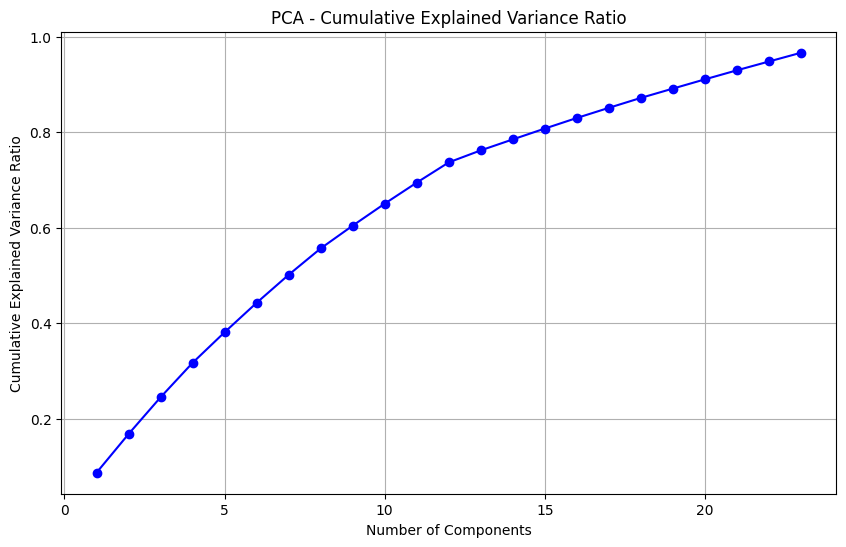

In [13]:
# Apply PCA to reduce dimensionality while preserving 95% of variance
pca = PCA(n_components=0.95)  # Keep 95% of variance

# Fit and transform the training data
xtrain = pca.fit_transform(xtrain)

# Transform the test data using the same PCA
xtest = pca.transform(xtest)

# Print the number of components and explained variance ratio
print(f"Number of components selected: {pca.n_components_}")
print(f"Total explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

## Model Training and Evaluation

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100),
    "MLPRegressor":MLPRegressor(hidden_layer_sizes=(11,11,11), max_iter=400),
    "ElasticNet":ElasticNet()
}

results = {}

for name, model in models.items():
    # Fit the model
    model.fit(xtrain, ytrain)

    # Make predictions on the test set
    ypred_test = model.predict(xtest)


    # Calculate metrics
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(ytest, ypred_test)),
        "MAE": mean_absolute_error(ytest, ypred_test),
        "R² Test": r2_score(ytest, ypred_test)
    }

results

{'Linear Regression': {'RMSE': 0.9853973287715153,
  'MAE': 0.8665274579798593,
  'R² Test': 0.0033968179947365673},
 'Random Forest': {'RMSE': 1.0142341825737116,
  'MAE': 0.8789825264421526,
  'R² Test': -0.05578623378192282},
 'XGBoost': {'RMSE': 1.0919191203433556,
  'MAE': 0.9181982458553039,
  'R² Test': -0.2237154688847578},
 'MLPRegressor': {'RMSE': 1.25969470585097,
  'MAE': 1.0596174405663847,
  'R² Test': -0.6286588234180279},
 'ElasticNet': {'RMSE': 0.9880205912676231,
  'MAE': 0.8739260423787839,
  'R² Test': -0.0019164329253318346}}

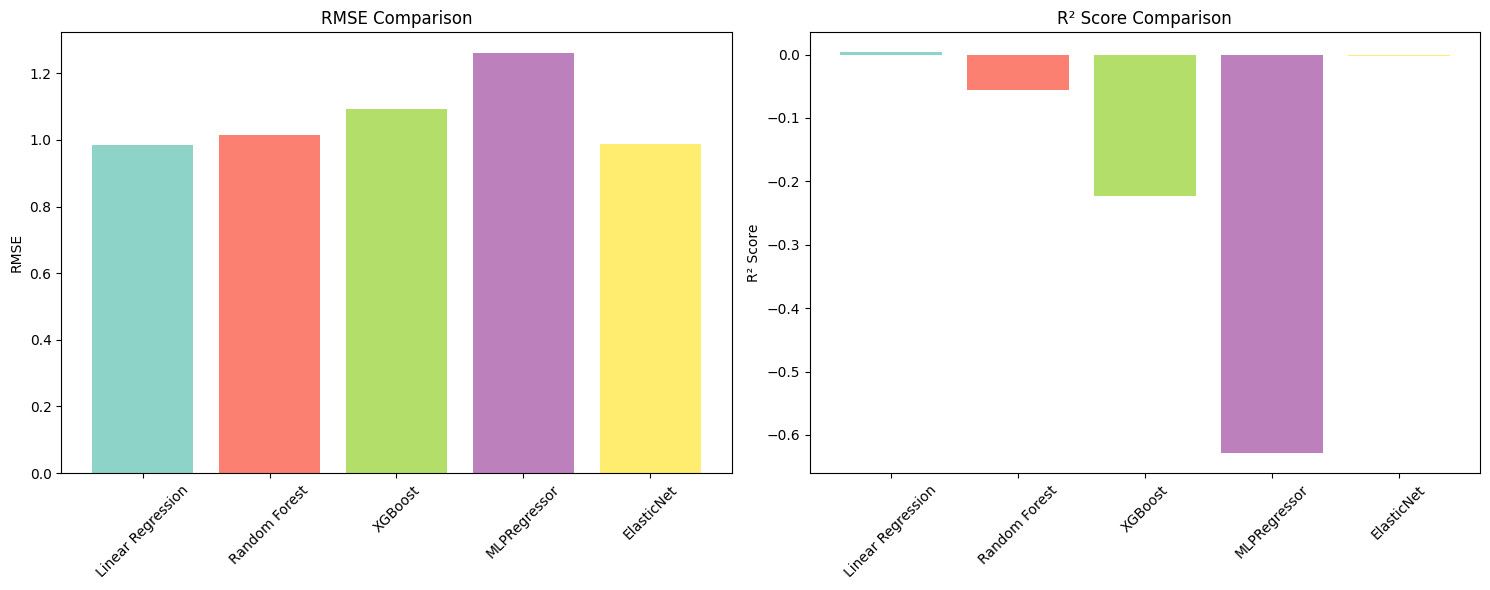

In [17]:
# Create a bar plot comparing model performances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Extract metrics
models = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in models]
r2_values = [results[model]['R² Test'] for model in models]

# Create color map for all models
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

# Plot RMSE comparison
ax1.bar(models, rmse_values, color=colors)
ax1.set_title('RMSE Comparison')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Plot R² comparison
ax2.bar(models, r2_values, color=colors)
ax2.set_title('R² Score Comparison')
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()